In [1]:
import matplotlib
import os
import numpy
import json
import collections

In [2]:
!find . -name Results_\* -type d

./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_0_MODEL_SolDB3d_Gadi
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_0_MODEL_SolDB3d_Magnus
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Magnus


In [3]:
# Below are the filenames to grab data from

bases = [
# "20190710_uw28/Weak_Scaling_32_Shifter_UW28_IO_2",
# "20190711_uw28/Strong_Scaling_64_UW28_IO_0",
# "uw27/Weak_Scaling_32_Shifter_UW27_without_IO",
# "uw27/Strong_Scaling_64_Shifter_UW27_without_IO",
"./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/",
"./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Magnus/"
]

In [4]:
maxproc = 9999999
minproc = 0
funcs_explicit = False # if true, use listed functions below, otherwise auto find slowest funcs
funcs_auto_how_many = 10

funcs = [
 'FeMesh.load()',
 'FeMesh.save()',
 'MeshVariable.load()',
 'MeshVariable.save()',
 'Swarm.load()',
 'Swarm.save()',
 'SwarmVariable.load()',
 'SwarmVariable.save()',
 'Figure.save()',
 'StokesSolver.solve()',
]

ignore_funcs = [
    'Container_Launch_Time',
]

In [5]:
# Each simulation stores it's timing data in a different file. 
# Here we grab all required files.
# Note wildcards, glob.glob() etc. 
nrpoc_set = set()
import glob
def grab_files(base):
    jsonguy = collections.defaultdict(lambda: [])
    for filename in glob.glob(base+"*.json"):
        with open(filename, 'r') as f:
            data = json.load(f)
            splitbase = filename.split(base)
            splitfile = splitbase[1].split("_")
            res = int(splitfile[1])
            nproc = int(splitfile[3])
            if nproc < minproc:
                continue
            if nproc > maxproc:
                continue
            nrpoc_set.add(nproc)
            print(filename)
            print("VRMS = {}".format(data[u'Other_data']["vrms"]))
            print("Res = {}".format(res))
            print("nproc = {}".format(nproc))
            jsonguy[(res,nproc)].append(data)
    return jsonguy
jsons = []
for baseguy in bases: 
    jsons.append(grab_files(baseguy))

./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/Res_128_Nproc_512_JobID_1435205.gadi-pbs.json
VRMS = 4.162845870713755
Res = 128
nproc = 512
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/Res_160_Nproc_1000_JobID_1435208.gadi-pbs.json
VRMS = 4.162845814917952
Res = 160
nproc = 1000
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/Res_16_Nproc_1_JobID_1435198.gadi-pbs.json
VRMS = 4.162845905192479
Res = 16
nproc = 1
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/Res_32_Nproc_8_JobID_1435200.gadi-pbs.json
VRMS = 4.1628459118392085
Res = 32
nproc = 8
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MODEL_SolDB3d_Gadi/Res_64_Nproc_64_JobID_1435202.gadi-pbs.json
VRMS = 4.162845914157546
Res = 64
nproc = 64
./Results_Weak_V29_SolDB3d_DIM_3_BASE_16_ORDER_2_TOL_1e-6_PENALTY_-1._IO_1_MOD

In [6]:
# Lets add in other_timing data
# This is data no recorded by `uw.timing` module, and is explicitly 
# recorded into the outputted json file.  This is used for Python load time
# and container start time. 
for jsonguy in jsons:
    for key,listjsons in jsonguy.items():
        for guy in listjsons:
            othertiming =  guy[u'Other_timing']
            for otherk, otherv in othertiming.items():
                othertiming[otherk] = [1, otherv]
            guy.update(othertiming)

In [7]:
if funcs_explicit:
    # Here we pick out the most expensive routines at 320^3 to graph
    guy32 = jsons[0][(160,1000)][0]
    list32 = []
    for key,val in guy32.items():
        if isinstance(val,list):
            list32.append([key,val[1]/float(val[0])])
    sortedlist = sorted(list32, key=lambda x: x[1], reverse=True) 
    funcs = []
    totmax = funcs_auto_how_many
    tot = 0
    for guy in sortedlist:
        if guy[0] in ignore_funcs:
            continue
        funcs.append(guy[0])
        tot+=1
        if tot > totmax:
            break
funcs

['FeMesh.load()',
 'FeMesh.save()',
 'MeshVariable.load()',
 'MeshVariable.save()',
 'Swarm.load()',
 'Swarm.save()',
 'SwarmVariable.load()',
 'SwarmVariable.save()',
 'Figure.save()',
 'StokesSolver.solve()']

In [8]:
# Collect data from jsons
def collect_data_from_jsons(jsonguy):
    funcdat = collections.defaultdict(lambda: [])
    for key,data in jsonguy.items():                      # all dicts
        for func in funcs:                                # funcs we want to look at
            for datum in data:                            # all runs for each res/nproc combo
                if func in datum:
                    datguy = datum[func]
                    dat = (key[0],key[1],datguy[1]/float(datguy[0]))
                    funcdat[func].append(dat)
                else:
                    print("{} not found in {}. Skipping".format(func,key))
                    continue
    return funcdat
funcdats = []
for jsonguy in jsons:
    result = collect_data_from_jsons(jsonguy)
    if result:
        funcdats.append(result)

In [9]:
# get averages if multiple datasets for given nproc/res
def get_averages(funcdatguy):
    avfuncdat = collections.defaultdict(lambda: [])
    for key, value in funcdatguy.items():
        counts = collections.defaultdict(lambda: [0,0.])
        for entry in value:
            dat = counts[entry[1]]
            dat[0]+=1
            dat[1]+=entry[2]
        for nproc, countdat in counts.items():
            avfuncdat[key].append((0,nproc,countdat[1]/float(countdat[0])))
    return avfuncdat
avfuncdats = []
for funcdat in funcdats:
    avfuncdats.append(get_averages(funcdat))

In [10]:
dats = avfuncdats

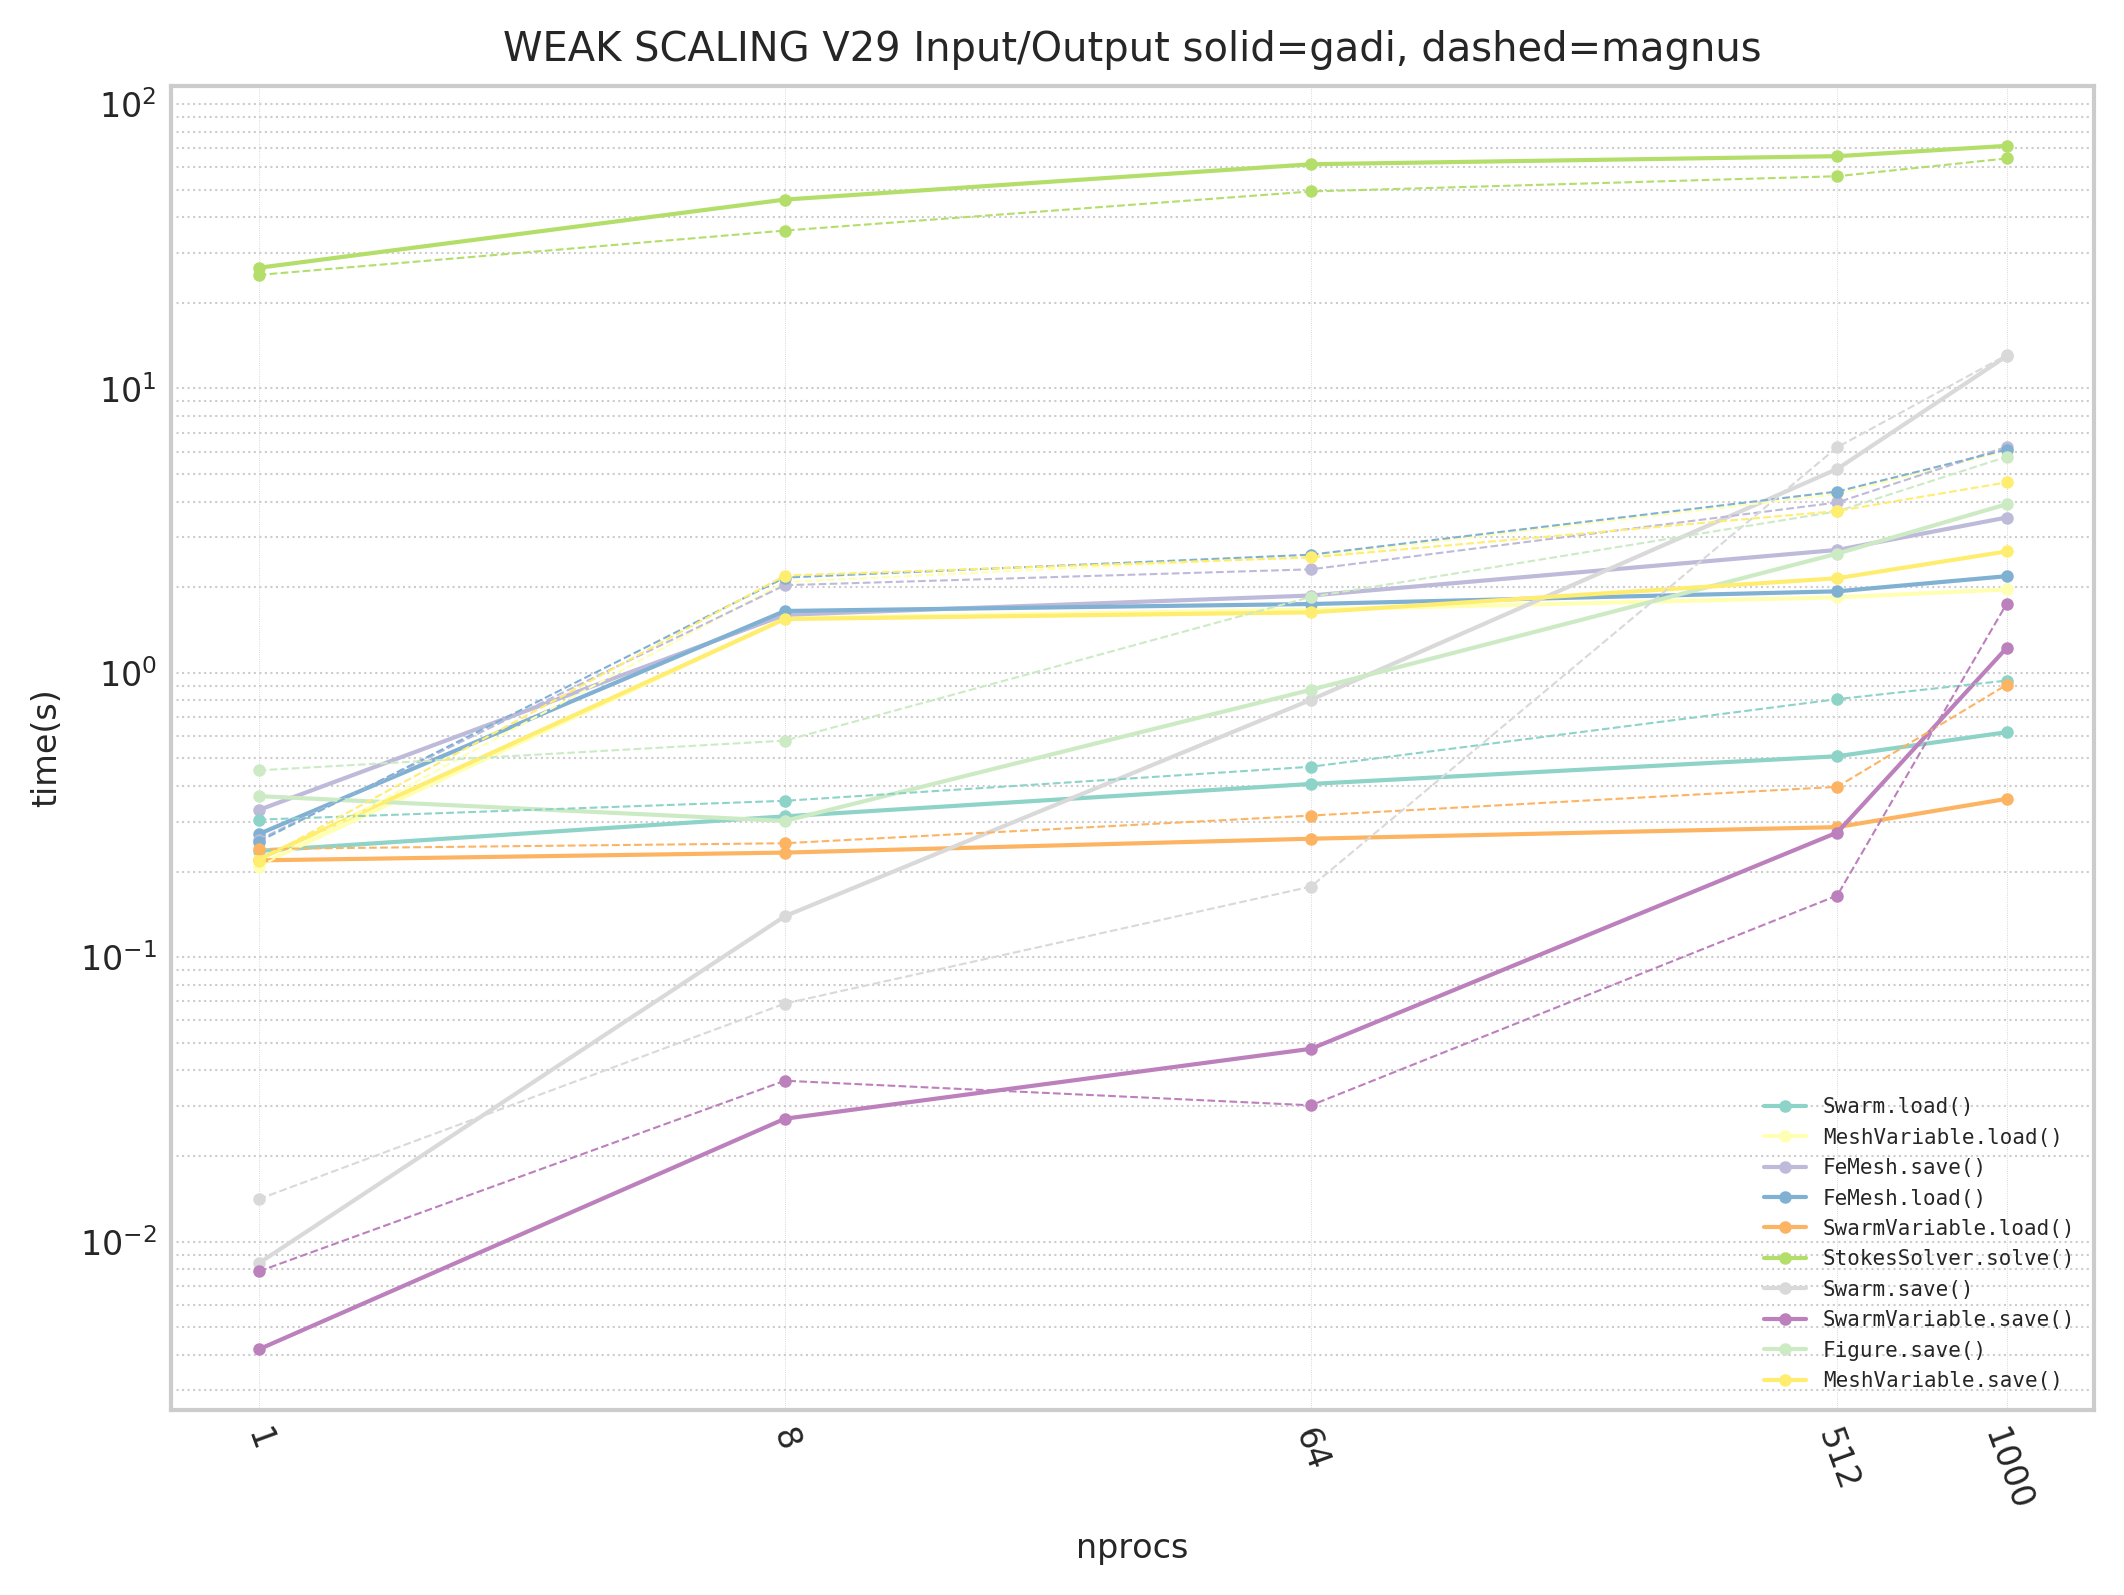

In [11]:
%matplotlib inline
# plot
import matplotlib.pyplot as plt
font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi=300, figsize=(8.27, 11.69/2.))
ax = plt.subplot(1,1,1,xscale='log', yscale='log')
# ax.set_title("Save operations")
ax.set_xlabel("nprocs")
ax.set_ylabel("time(s)")
sortedprocs = sorted(list(nrpoc_set))
ax.xaxis.set_ticks(sortedprocs)
ax.xaxis.set_ticklabels(sortedprocs, rotation=-70)
ax.grid(axis="y", which="both",linestyle=':',linewidth=0.5)
ax.grid(axis="x", linestyle=':',linewidth=0.2)
linestyles = ['-','--',':']
linewidths = [1.,0.5,0.5]
plt.title("WEAK SCALING V29 Input/Output solid=gadi, dashed=magnus")
from matplotlib.pyplot import cm
import numpy as np
colours = cm.Set3(np.linspace(0,1,len(funcs)))

for index, dat in enumerate(dats):
    colind = 0
    for key, value in dat.items():
        xy = []
        for entry in value:
            xy.append((entry[1],entry[2]))
        sorteddat = sorted(xy, key=lambda x: x[0], reverse=False) 
        if key=='Total_Runtime':
            col = "black"
            lw  = 1.5
        else:
            col = colours[colind]
            lw = 0.5
        if index!=0: key=None
        ax.plot([x[0] for x in sorteddat],[x[1] for x in sorteddat], label=key, color=col, linestyle=linestyles[index], marker='o', markersize=2,linewidth=linewidths[index])
        colind+=1
ax.legend( prop={'family': 'monospace', 'size':5})

In [13]:
fig.savefig("weak_scaling_io_v29")